# MCMC for the mass distribution of EMRIs

In [1]:
selection_effects = True # Select True if you want to complicate your life.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import matplotlib as mpl
import seaborn as sns


%matplotlib inline
np.random.seed(1234)


params = {'axes.labelsize': 18,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 18,
          'axes.linewidth': 1,
          'legend.fontsize': 15,
          'xtick.labelsize': 18,
          'xtick.top': True,
          'ytick.labelsize': 18,
          'ytick.right': True,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'axes.formatter.limits' : (-3,3)}

mpl.rcParams.update(params)

We fit a BH mass functionsource parameter given by the mass, $\theta=M$. This example follows the EMRI mass function [e-Print: 1004.1921 ("GTV")]:

$$\frac{dN}{d\ln M}=A_0\big(\frac{M}{M_*}\big)^{\alpha_0} \quad\Rightarrow\quad p(M|\lambda)=\mathcal{N} M^{\alpha_0-1} = \frac{\alpha_0}{M^{\alpha_0}_\text{max}-M^{\alpha_0}_{\text{min}}} M^{\alpha_0-1}.$$

We are interested in the $ \lambda=\alpha_0$ population parameter. We are assuming that the amplitude $A_0$ does not carry information about the system, but only about the rate of events.

In [3]:
def model(lnM,alpha):
    
    """
    Model for p(d|lambda).
    
    Input:
    
    - data    (The noisy generated data where we expect the masses to be.)
    - alpha   (Spectral index of the mass distribution.)
    
    """
    
    M = np.exp(lnM) # mass observations
    norm  = alpha/(M_max**alpha-M_min**alpha)
    
    
    return norm*M**(alpha-1)

In [4]:
"""
Parameters
"""

N_obs = 100
N_samps_likelihoods = 10
N_samps_selfunction = 100000 # Needs to be high to sample well the selection function's integral.


alpha0_t = 0.00001 # Choose flat spectral profile.
M_min=10000. ;   logM_min = np.log(M_min) # M runs from 10^4
M_max=10000000.; logM_max = np.log(M_max) # to 10^7 solar masses.


Starting from the probability density $p(M|\lambda)=\mathcal{N} M^{\alpha_0-1}$, we can use the method of inversion to get the source parameter M. In particular, we define the cumulative density function,

$u:=\text{CDF}(M)= \mathcal{N}\int_{M_\text{min}}^{M}M^{\alpha_0-1}dM = \alpha_0^{-1}\mathcal{N}M^{\alpha_0}\big|_{M_\text{min}}^{M}=\alpha_0^{-1}\mathcal{N}(M^{\alpha_0}-M^{\alpha_0}_{\text{min}})$.

Now, we get M in terms of $u$, 

$\quad M^{\alpha_0}=\alpha_0\mathcal{N}^{-1} u +M^{\alpha_0}_{\text{min}}\quad\Longrightarrow \quad \ln M =\frac{1}{\alpha_0} \ln\big[(M^{\alpha_0}_\text{max}-M^{\alpha_0}_{\text{min}})\, u +M^{\alpha_0}_{\text{min}}\big]\quad $ (true parameter distribution).

In [5]:
def log_M(alpha, N, Mmax,Mmin):

    """
    Analytical function to draw samples following a power law. It helps in the definition of the selection function for the MCMC analysis.
    
    Inputs:
    
    - alpha: the spectral index chosen.
    - N: the number of events of the true underlying population.
    - Mmax, Mmin: limits of integration, corresponding to minimum and maximum mass of underlying pop.
    """
    
    return alpha**-1 * np.log((Mmax**(alpha)-Mmin**(alpha))*np.random.uniform(size=N)+ Mmin**(alpha)*np.ones(N))

In [6]:
"""
Noise characteristics.
"""

sigma = 0.1
dth = 13.0
noise = np.random.normal(0,sigma,size = N_obs)

"""
Data draws.
"""

u = np.random.uniform(size=N_obs)
logM_t=log_M(alpha0_t, N_obs, M_max,M_min)
d_i = noise + logM_t  # observation model made of noise + true population.
d_i_selbias = d_i[d_i>dth]
N_det = len(d_i_selbias)

if selection_effects==True: print('Out of', N_obs,'possible events,', N_det,'are detected.')

"""
Data array. The structure of data is such that Data[i,j] is the jth posterior sample from event i.
We assume the observation model p(d|theta) is a normal gaussian with noise variance sigma.

"""

logM_obs=np.zeros((N_obs,N_samps_likelihoods))
logM_obs_selbias=np.zeros((N_det,N_samps_likelihoods))

for i in np.arange(N_obs):
    logM_obs[i,:]=np.random.normal(d_i[i],sigma,size=N_samps_likelihoods)
for i in np.arange(N_det):
    logM_obs_selbias[i,:]=np.random.normal(d_i_selbias[i],sigma,size=N_samps_likelihoods)
    
if selection_effects == True: 
    data = logM_obs_selbias
else:
    data =logM_obs

Out of 100 possible events, 47 are detected.


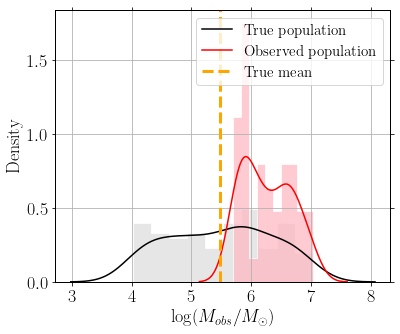

In [7]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
plt.hist(np.log10(np.exp(d_i)),density=True,bins=10,histtype = 'stepfilled',
                               color ='gainsboro', alpha=0.7, edgecolor='white')
sns.kdeplot(np.array(np.log10(np.exp(d_i))), label='True population',c='k')

if selection_effects==True:
    plt.hist(np.log10(np.exp(d_i_selbias)),density=True,bins=10,histtype = 'stepfilled',
                               color ='lightpink', alpha=0.7, edgecolor='white')
    sns.kdeplot(np.array(np.log10(np.exp(d_i_selbias))), label='Observed population',c='red')
    
plt.axvline(x=np.log10(np.exp(np.mean(logM_t))), label='True mean', c='orange',ls='--',lw=3)

plt.xlabel('$\log(M_{obs}/M_\odot)$')
plt.ylabel('Density')
plt.legend()

In [8]:
from scipy.special import erfc

# Limits of (flat) hyperpriors.

hyperprior_min = -10.0
hyperprior_max = 10.0


def selection_function(Lambda,number_samples_for_integration,upper_limit,lower_limit,noise_var,threshold):
    
    """
    This function is redefined in such a way that the hyperparameter appears as an input.
    One must generate samples at each iteration of lambda in the MCMC.
    """
    theta_ij = log_M(Lambda,number_samples_for_integration,upper_limit,lower_limit)
    
    return np.sum(0.5*erfc((threshold-theta_ij)/np.sqrt(2)/noise_var))/number_samples_for_integration

def log_likelihood(params, data):
    
    """
    Support.
    """
     
    support = ( # Here is the support limits for hyperpriors.
                (params[0] >= hyperprior_min)&
                (params[0] <= hyperprior_max)
                )
    
    log_likelihood=0

    """
    Selection function.
    """
    
    if selection_effects == True:
        pdet = selection_function(params[0],N_samps_selfunction,M_max,M_min,sigma,dth)
        Nsources = N_det
    else: 
        pdet = 1.
        Nsources = N_obs
    
    """
    Population likelihood.
    """

    for i in np.arange(Nsources):
        
        ppop_ij = model(data[i,:],params[0])           # N_samp-long array for population model.
        sum_ppop = np.sum(ppop_ij)                     # Internal sum of population model over N_samp.
        log_likelihood += np.log(sum_ppop/pdet)        # Add the samples drawn over N_obs in the loop
                                                       # and divide by the selection function at each step.
    
    
    """
    Output without infinities and within the specified hyperpriors.
    """
    out = np.where(support,log_likelihood,-np.inf)     # Only retain likelihood if supported.
    
    
    # Force nans away.
    if np.isfinite(out):
        return out
    else:
        return -np.inf

In [9]:
n_iter = 10000
ndim = 1; nwalkers = 2

pos_init0 = [alpha0_t]
p0 = pos_init0*(1+0.001* np.random.randn(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=[data])

sampler.run_mcmc(p0, n_iter, progress=True)

100%|████████████████████████████████████| 10000/10000 [01:29<00:00, 111.19it/s]


State([[-0.22399703]
 [ 0.12214626]], log_prob=[-622.40269654 -624.15305572], blobs=None, random_state=('MT19937', array([2209347806, 1455763380,  709510636, 3440843077, 3752617489,
        952088491,  775820782, 3265816795, 2607858076, 2131653488,
        367262757,   69774036, 2471148712,  334551069, 2530767509,
       3778372721, 2232825961, 2484599706,  536755321, 1726053193,
       1405787848, 1403658940, 1058375347, 3711841685, 1464080188,
       4088532797,  521907408, 2551004495,  508623852, 1870710050,
       1507605330, 1357887546, 1662696059,  487750145, 2972828509,
       4127227867, 2933099517, 3169747188, 3396143777, 2543587073,
        177375178, 2909857872, 1445229585, 2815489797, 2083182109,
        997998635, 3615565821, 2455040128,  523563430, 1172772658,
        342667079,   72367162, 1542499455,  622308796,  699108808,
       4186053107,  852556511,  760193008,    8451847, 1700102640,
       1797000450, 4162255694, 3043794009, 1781440522, 2423510124,
       3972951

In [10]:
"""
Collect the samples here.
"""
burnin = 1500

chains = sampler.get_chain(discard=burnin, thin=1, flat=False)
alpha_samples = chains[:,:,0].flatten()

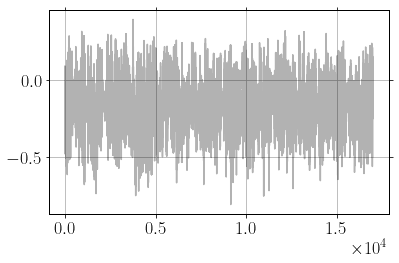

In [11]:
plt.plot(alpha_samples, "k", alpha=0.3)
plt.tight_layout()
plt.show()

### Fisher estimates

In [12]:
# Estimates without selection effects.

def Dalpha(Nobs,alpha,Mmin,Mmax):
    """
    This expression is only valid for 1D fitting, and crucially it only accounts for the first 
    term in the FM in the case, in the case in which there are no selection effects.
    In short, be extremely careful in using it. However, it is an excellent approximation in the case without selection effects.
    """
    den = Nobs * (alpha**-2 - (Mmax**alpha * Mmin**alpha * np.log(Mmax/Mmin)**2)/(Mmax**alpha-Mmin**alpha)**2)
    return np.sqrt(1/den)

def gaussian(d,mu,Sigma_sq): 
    num = np.exp(-0.5*(d-mu)**2/Sigma_sq)
    den = np.sqrt(2*np.pi*Sigma_sq)
    return num/den

In [13]:
# Estimates with selection effects.

def pdet_lambda(theta):         return 0.5*N_samps_selfunction**-1*np.sum(erfc((dth-theta)/np.sqrt(2)/sigma))
def dpdet_dlambda(theta):       return 0.5*N_samps_selfunction**-1*np.sum(erfc((dth-theta)/np.sqrt(2)/sigma)*theta)    #to check.
def ddpdet_ddlambda(theta):     return 0.5*N_samps_selfunction**-1*np.sum(erfc((dth-theta)/np.sqrt(2)/sigma)*theta**2) #to check.

def pdet_theta(theta):          return np.sum(0.5* erfc((dth-theta)/np.sqrt(2)/sigma))

def dppop_dlambda(theta, Lambda =alpha0_t,theta_min=M_min,theta_max =M_max):  

    norm= theta_max**Lambda -theta_min**Lambda
    num = np.exp(theta)**(Lambda-1) * (norm+norm*Lambda*theta-theta_max**Lambda*Lambda*np.log(theta_max)+ theta_min**Lambda*Lambda*np.log(theta_min))
    den = norm**2
    return np.sum(num/den)

def ddppop_ddlambda(theta, Lambda =alpha0_t,theta_min=M_min,theta_max =M_max):  

    norm = theta_max**Lambda -theta_min**Lambda
    num_1 = theta_max**(2*Lambda)*(theta-np.log(theta_max))*(2+Lambda*theta-Lambda* np.log(theta_max))
    num_2 = theta_min**(2*Lambda)*(theta-np.log(theta_min))*(2+Lambda*theta-Lambda* np.log(theta_min))
    num_3 = theta_max**(Lambda)*theta_min**(Lambda)*(-2*Lambda*theta**2+2*(np.log(theta_max)+np.log(theta_min))+Lambda*(np.log(theta_max)**2-4*np.log(theta_max)*np.log(theta_min)+np.log(theta_min)**2)+2*theta*(-2+Lambda*(np.log(theta_max)+np.log(theta_min))))
    num = num_1 +num_2 + num_3
    den = norm**3
    return np.sum(np.exp(theta)**(Lambda-1)*num/den)

def Gamma_lambda(theta,Lambda =alpha0_t):
    
    # Only the first term in Gamma_lambda, integrated out with theta_ij from p(theta|lambda).
    # Watch out with the minus sign!
    
    ppop = np.sum(model(theta,Lambda))
    
    doub_der = (dppop_dlambda(theta)**2-ppop*ddppop_ddlambda(theta))/ppop**2 + (pdet_lambda(theta)*ddpdet_ddlambda(theta)-dpdet_dlambda(theta)**2)/pdet_lambda(theta)**2
    first_term = N_det *doub_der * pdet_theta(theta)/pdet_lambda(theta)
    return first_term

def Gamma_lambda_v1(theta,Lambda =alpha0_t):
    
    # Only the first term in Gamma_lambda, integrated out with theta_ij from p(theta|lambda).
    # Watch out with the minus sign!
    
    ppop = np.sum(model(theta,Lambda))
    
    doub_der = (dppop_dlambda(theta)**2-ppop*ddppop_ddlambda(theta))/ppop**2 + (pdet_lambda(theta)*ddpdet_ddlambda(theta)-dpdet_dlambda(theta)**2)/pdet_lambda(theta)**2
    first_term = N_det *doub_der * pdet_theta(theta)/pdet_lambda(theta)
    return first_term

In [24]:
theta_ij = log_M(alpha0_t,N_samps_selfunction,M_max,M_min) #samples drawn from PDF to be used in the MC integral.


print('First derivative pdet:', dpdet_dlambda(theta_ij))
print('Second derivative pdet:', ddpdet_ddlambda(theta_ij))
print('First derivative ppop:', dppop_dlambda(theta_ij))
print('Second derivative ppop:', ddppop_ddlambda(theta_ij))


print('First term Gamma_lambda:', Gamma_lambda(theta_ij))

First derivative pdet: 6.582474930340792
Second derivative pdet: 96.17245366212882
First derivative ppop: -0.5150474412648878
Second derivative ppop: 0.6344620820292357
First term Gamma_lambda: 18056809.663590778


In [30]:
print('precision without selection effects:',Dalpha(N_obs,alpha0_t,M_min,M_max))
print('Precision found numerically:',np.sqrt(1/Gamma_lambda(theta_ij)))

precision without selection effects: 0.04978162894482727
Precision found numerically: 0.0002353311894565933


In [31]:
np.sqrt(1/Gamma_lambda(theta_ij))

0.0002353311894565933

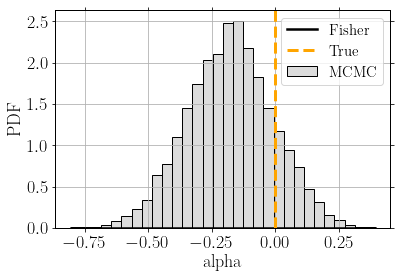

In [32]:
"""
Posteriors with Fisher estimates
"""


_, bins_alpha, _= plt.hist(alpha_samples, 30, histtype = 'bar', color ='gainsboro', density=True, edgecolor='black', label='MCMC')
bins_alpha= np.array(bins_alpha)

if selection_effects == False: 
    
    # Fisher estimate without selection effects.
    Da = Dalpha(N_obs,alpha0_t,M_min,M_max)
    plt.plot(bins_alpha, gaussian(bins_alpha,alpha0_t,Da**2), color='black', lw=2.5,label='Fisher')
    
else:
    Da=np.sqrt(1/Gamma_lambda(theta_ij))#dalpha_v1(logM_t,alpha0_t)
    plt.plot(bins_alpha, gaussian(bins_alpha,alpha0_t,Da**2), color='black', lw=2.5,label='Fisher')
    

plt.axvline(x=alpha0_t, label='True', c='orange',ls='--',lw=3)
plt.xlabel('alpha')
plt.ylabel('PDF')
plt.legend()
plt.show()

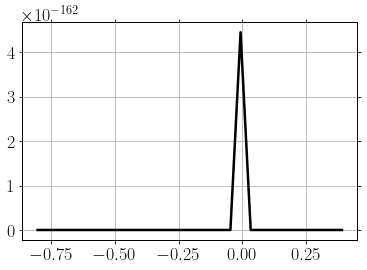

In [33]:
Da=np.sqrt(1/Gamma_lambda(theta_ij))
plt.plot(bins_alpha, gaussian(bins_alpha,alpha0_t,Da**2), color='black', lw=2.5,label='Fisher')

# Dumpster

In [ ]:
# from scipy.misc import derivative

# theta_mean = 12.62
# M_mean = np.exp(theta_mean)

# def ppop_mean(hyperpar): return hyperpar/(M_max**hyperpar-M_min**hyperpar)*M_mean**(hyperpar-1)
# def log_ppop(hyperpar): return np.log(ppop_mean(hyperpar))

# print('first der:', derivative(log_ppop, alpha0_t, dx=1e-4,n=1,order=3))
# print('second der:',derivative(log_ppop, alpha0_t, dx=1e-4,n=2,order=3))

In [ ]:

# def log_M_norm(alpha, Mmax,Mmin):
#     return alpha/(Mmax**(alpha)-Mmin**(alpha))


# def selection_function_firstderiv(Lambda,number_samples_for_integration,upper_limit,lower_limit,noise_var,threshold):
    
#     theta_ij = log_M(Lambda-1.0,number_samples_for_integration,upper_limit,lower_limit)
    
#     #return np.sum((Lambda-1.0)*log_M_norm(Lambda,upper_limit,lower_limit)*(theta_ij**-10)/np.sqrt(2)/noise_var/log_M_norm(Lambda-1.0,upper_limit,lower_limit))/number_samples_for_integration
#     return np.sum((Lambda-1.0)*log_M_norm(Lambda,upper_limit,lower_limit)*0.5*erfc((threshold-theta_ij)/np.sqrt(2)/noise_var)/log_M_norm(Lambda-1.0,upper_limit,lower_limit))/number_samples_for_integration
#     #return np.sum(log_M_norm(Lambda,upper_limit,lower_limit)/log_M_norm(Lambda-1.0,upper_limit,lower_limit))

# def selection_function_firstderivAlt(Lambda,number_samples_for_integration,upper_limit,lower_limit,noise_var,threshold):
    
#     theta_ij = log_M(Lambda,number_samples_for_integration,upper_limit,lower_limit)
    
#     #return np.sum((Lambda-1.0)*(theta_ij**-10)/np.sqrt(2)/noise_var/np.exp(theta_ij))/number_samples_for_integration
#     return np.sum((Lambda-1.0)*0.5*erfc((threshold-theta_ij)/np.sqrt(2)/noise_var)/np.exp(theta_ij))/number_samples_for_integration
#     #return np.sum(1.0/np.exp(theta_ij))/number_samples_for_integration

# def selection_function_secondderiv(Lambda,number_samples_for_integration,upper_limit,lower_limit,noise_var,threshold):
    
#     theta_ij = log_M(Lambda-2.0,number_samples_for_integration,upper_limit,lower_limit)
    
#     return np.sum((Lambda-2.0)*(Lambda-1.0)*log_M_norm(Lambda,upper_limit,lower_limit)*0.5*erfc((threshold-theta_ij)/np.sqrt(2)/noise_var)/log_M_norm(Lambda-2.0,upper_limit,lower_limit))/number_samples_for_integration

# def d_pdet_lambda(hyperpar): return selection_function_firstderiv(hyperpar,N_samps_selfunction,M_max,M_min,sigma,dth)
# def Alt_d_pdet_lambda(hyperpar): return selection_function_firstderivAlt(hyperpar,N_samps_selfunction,M_max,M_min,sigma,dth)
# def dd_pdet_lambda(hyperpar): return selection_function_secondderiv(hyperpar,N_samps_selfunction,M_max,M_min,sigma,dth)

In [ ]:

# print(d_pdet_lambda(alpha0_t)/pdet_lambda(alpha0_t))
# print(Alt_d_pdet_lambda(alpha0_t)/pdet_lambda(alpha0_t))
# print('ratio:', d_pdet_lambda(alpha0_t)/Alt_d_pdet_lambda(alpha0_t))

In [ ]:
# print(d_pdet_lambda(alpha0_t))
# Alt_d_pdet_lambda(alpha0_t)

In [ ]:
# Dumpster.

def dppop_dlambda_v1(theta, Lambda = alpha0_t,theta_min=M_min,theta_max=M_max):  

    term1 = Lambda**-1
    term2 = theta -np.log(theta_min)
    term3 = - theta_max**Lambda/(theta_max**Lambda -theta_min**Lambda)*(np.log(theta_max/theta_min))
    return np.sum(term1 + term2 + term3)


#def ddppop_ddlambda(theta):     return np.sum(model(theta,alpha0_t)*theta**2)

#def term_1(theta): return (ddppop_ddlambda(theta)-ddpdet_ddlambda(theta))*pdet_theta(theta)/pdet_lambda(theta)

In [ ]:
# Helper functions

def pdet_lambda(hyperpar): return selection_function(hyperpar,N_samps_selfunction,M_max,M_min,sigma,dth)
def pdet_theta(theta):     return 0.5* erfc((dth-theta)/np.sqrt(2)/sigma)
def ppop(theta,hyperpar):  return model(theta,hyperpar)

def Gamma_lambda_v1(theta,hyperpar): 
    
    ptheta=np.sum(pdet_theta(theta))
    plambda = pdet_lambda(hyperpar)
    sigma_lambda_prime = 6.571860642416611
    sigma_lambda_doubprime = 96.0130766100902
    num = (-0.00731241 + 5.03501* ptheta-0.1596* ptheta)*plambda**2 - ptheta*sigma_lambda_prime**2 + ptheta*plambda*sigma_lambda_doubprime
    den = pdet_lambda(hyperpar)**3
    return N_det*num/den
    #return N_det*(-0.00731241 + 5.03501* ptheta-0.1596* ptheta)/pdet_lambda(hyperpar)

    
def dalpha_v1(theta,hyperpar):    return np.sqrt(1/Gamma_lambda_v1(theta,hyperpar))

In [ ]:
print('precision without selection effects:',Dalpha(N_obs,alpha0_t,M_min,M_max))
print('precision with selection effects:',dalpha_v1(logM_t,alpha0_t))